# Pre-Processing Dataset

Here I generate the `gal_fname1` which cointains the columns needed to this study: `Mr, R, R/R200, v_los, v_circ, orbital, infall, interloper`.


In [1]:
%cd ../

/Users/jesteves/Documents/GitHub/galaxyFormation


In [2]:
import sys
sys.path.append('./scripts')
from file_loc import FileLocs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
import astropy.table as Table
import astropy.io.ascii as at

# Reading Initial Data

In [4]:
fl = FileLocs(dataset='sdss')

cat = fl.load_catalogs('cluster/main')
gal = fl.load_catalogs('galaxy/raw')

Loading Catalog: ./data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017.csv
Loading Catalog: ./data/catalogs/SDSS/groups_deCarvalho2017_R200m_galaxies_final_flag_johnnyheq.csv


In [5]:
cat

Yang,RA,DEC,redshift,N200,logM200c,logM200m,R200c,R200m,thetaR200,thetaR200m,vcirc_c,vcirc_m
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
2,240.5602,16.1113,0.035999998450279236,525,15.444902420043945,15.61043080796355,2.8714284896850586,3.880159897239745,0.7795811316295294,1.0534475724189225,2041.7840576171875,1887.7175813096123
4,247.1149,40.8317,0.029999999329447746,217,14.814902305603027,14.988838641010085,1.7714285850524902,2.4220034873237517,0.5730670271152717,0.7835316364742502,1257.8946533203125,1168.0954840010763
5,247.1633,39.4674,0.029999999329447746,277,14.9649019241333,15.138926939889993,2.0,2.7177167877362454,0.6470111436516279,0.8791965384498562,1411.3817138671875,1310.7135159645927
6,167.6936,28.5374,0.032999999821186066,167,14.754902839660645,14.927840689026137,1.6857142448425293,2.3045122256737995,0.4975147606695648,0.6801442623443363,1201.785400390625,1116.2906247336416
7,351.1194,14.6251,0.041999999433755875,106,14.664902687072754,14.835094504183962,1.571428656578064,2.127630582418425,0.36826592735879554,0.4986124388818472,1122.9947509765625,1044.1083602597816
8,239.5372,27.3133,0.09000000357627869,183,15.254901885986328,15.411329095121902,2.442857265472412,3.1653055595608754,0.28232277514615234,0.3658166554840595,1778.5684814453125,1661.893369756073
9,241.5673,18.1483,0.03799999877810478,143,14.634902000427246,14.805763776646277,1.54285728931427,2.0882845757704884,0.39776457242354135,0.5383813998714762,1096.8115234375,1018.9044815412407
10,223.2712,16.724,0.04500000178813934,106,14.37490177154541,14.540970333947133,1.2714285850524902,1.6928023827999323,0.27907195269288665,0.3715613166955407,899.2819213867188,834.3119339941352
11,10.4693,-9.3997,0.0560000017285347,156,15.11490249633789,15.281540679227374,2.2142856121063232,2.957436412692569,0.3955778673545872,0.5283403209497024,1589.443603515625,1480.6726552656237


In [6]:
gal

Yang,objid,specobjid,distance,ra,dec,mr_petro,mu,mg,mr,mi,mz,mu_Err,mg_err,mr_err,mi_err,mz_err,photo_z,photo_zErr,z,zErr,fracDeV_i,bpt,mass,mass_p16,mass_p84,sfr,sfr_p16,sfr_p84,ssfr,ssfr_p16,ssfr_p84,mass_fire,mass_fire_p16,mass_fire_p84,age_fire,age_fire_p16,age_fire_p84,score
int64,int64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,1237665371723661557,2477083489036429312,135.738834222632,241.298564879647,18.26084584558,17.48854,19.75721,18.21501,17.37634,16.95171,16.6381,0.0609615,0.008713962,0.005935783,0.006074779,0.01416315,0.117663,0.021792,0.1065375,2.452199e-05,0.4905942,2,10.58861,10.49308,10.68633,-0.07285602,-0.5421439,0.2960085,-10.72217,-11.2,-10.334,37374590000.0,24188360000.0,49324600000.0,8078016000.0,4779446000.0,10227080000.0,0.856566
2,1237665428107821415,2445511568356567040,171.508636873903,238.56412770826,18.2407672679196,16.31932,18.71298,16.98568,16.19633,15.843,15.52826,0.03205757,0.004633865,0.003692101,0.003854876,0.007470628,0.064453,0.01715,0.04995852,1.184666e-05,1.0,-1,10.32373,10.22839,10.42026,-1.198831,-2.6019,-0.5137408,-11.56485,-13.00833,-10.86466,18488130000.0,15023600000.0,22695060000.0,4579532000.0,3829858000.0,5779013000.0,0.8308808
2,1237665428644823420,null,173.498011054365,239.074646969925,18.6315851506837,17.74369,21.26342,19.24348,17.60027,17.03238,16.6224,0.2952045,0.02036217,0.008256375,0.00774688,0.01928836,0.302899,0.015353,-99.0,-99.0,1.0,null,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.8757436
2,1237665428644888775,2443361467412539392,163.246759660063,239.132308823493,18.4659109006879,17.66026,20.36982,18.48156,17.50261,17.07461,16.67447,0.08424775,0.0088269,0.00607071,0.006116295,0.0135279,0.116192,0.01191,0.1116601,2.594067e-05,0.9906603,-1,10.69513,10.60143,10.78922,-0.998744,-2.359543,-0.2821258,-11.75,-13.12561,-11.03058,45495570000.0,38429500000.0,61801870000.0,5679056000.0,4479576000.0,8977626000.0,0.8765266
2,1237665428645019674,2443369988627654656,154.033811068271,239.475548138904,18.460401128184,17.12686,18.3683,17.3434,17.02203,16.85099,16.73031,0.03064607,0.005939393,0.006199671,0.007703912,0.02512163,0.026301,0.006888,0.03083848,7.006724e-06,0.0,1,9.003388,8.943274,9.093821,-0.4763157,-0.7448473,-0.1514794,-9.546676,-9.815816,-9.220427,701867800.0,473997300.0,955057300.0,3380052000.0,2130594000.0,4779446000.0,0.8807181
2,1237665428645019925,2443374661552072704,148.86836495571,239.488718264673,18.3716150837489,16.93894,19.32717,17.59304,16.73839,16.34778,16.02539,0.05376307,0.006460988,0.00485328,0.005070472,0.01194319,0.087452,0.01579,0.06998631,1.652068e-05,1.0,5,10.47901,10.38828,10.56711,-1.080323,-2.450889,-0.4215836,-11.6034,-12.92778,-10.96268,33769590000.0,28210060000.0,38845690000.0,10227080000.0,8477842000.0,10776850000.0,0.8807181
2,1237665428645019992,2443374936429979648,148.369846653478,239.541013372224,18.384544561721,17.08099,18.67793,17.43205,16.95458,16.73261,16.56703,0.04618878,0.006999946,0.006659066,0.008382308,0.02802264,0.0323,0.013754,0.04581517,1.127866e-05,0.09286518,1,9.531749,9.457346,9.622227,-0.3694099,-0.6738763,-0.08837827,-9.952034,-10.29066,-9.656939,1588126000.0,593651800.0,2582601000.0,3529988000.0,531287500.0,5379186000.0,0.8807181
2,1237665428645150983,2475958683289282560,143.159722457709,239.802004213502,18.3847876820098,17.72339,19.95294,18.32212,17.49247,17.03662,16.71286,0.07685973,0.009251545,0.00685283,0.006859739,0.01706356,0.105572,0.024994,0.1412849,2.340153e-05,1.0,5,10.8653,10.75991,10.97128,0.4590226,-0.04664442,0.931246,-10.44528,-10.96968,-9.990323,33132700000.0,22517430000.0,50572080000.0,4079749000.0,2180572000.0,5978926000.0,0.9000694
2,1237665428645216628,2475963631091607552,129.870359401985,239.948953810887,18.1955300

# Task to perform

1. Create New Variables
2. Create Masks
3. Assign Dynamical Classification

## New Variables

In this section we compute the distance from the center and the phase space normalized variables (`R/R_200`, `v_los/v_circ`). Also, we assign k-correction and absolute magnitudes.


In [7]:
cid  = np.array(cat['Yang'])

ra_c = np.array(cat['RA'])
de_c = np.array(cat['DEC'])
zcls = np.array(cat['redshift'])

theta200m = np.array(cat['thetaR200m']) # degrees
theta200c = np.array(cat['thetaR200']) # degrees

r200m = np.array(cat['R200m'])
# r200c = np.array(cat['R200c'])
m200c = np.array(cat['logM200c'])

vcirc_m =  np.array(cat['vcirc_m'])
vcirc_c =  np.array(cat['vcirc_c'])

In [8]:
import esutil
gcid = np.array(gal['Yang'])
cid  = np.array(cat['Yang'])

key = esutil.numpy_util.match(cid,gcid)

In [9]:
into_cls, into_gal = key[0], key[1]

### Assigning new variables

In [10]:
gal.columns

<TableColumns names=('Yang','objid','specobjid','distance','ra','dec','mr_petro','mu','mg','mr','mi','mz','mu_Err','mg_err','mr_err','mi_err','mz_err','photo_z','photo_zErr','z','zErr','fracDeV_i','bpt','mass','mass_p16','mass_p84','sfr','sfr_p16','sfr_p84','ssfr','ssfr_p16','ssfr_p84','mass_fire','mass_fire_p16','mass_fire_p84','age_fire','age_fire_p16','age_fire_p84','score')>

In [11]:
columns = ['Yang','ra','dec','distance','mr_petro','mg','mr','mass','z','zErr','bpt','ssfr','sfr']
data = gal[columns][into_gal].copy()

data['Yang'] = cid[into_cls]

# data['R200c'] = r200c[into_cls]
data['R200m'] = r200m[into_cls]

data['M200c'] = m200c[into_cls]
data['redshift'] = zcls[into_cls]

In [12]:
distance = np.array(gal['distance'])/60. # degrees
data['Rm'] = distance[into_gal]/theta200m[into_cls]
data['Rc'] = distance[into_gal]/theta200c[into_cls]
data['R']  = data['Rm']*data['R200m']

In [13]:
star_forming = (data['ssfr']>-11.0)
quenching    = np.logical_not(star_forming)
data['SF'] = np.array(star_forming).astype(int)

In [14]:
from astropy.constants import G, c
def get_los_velocity(z_gal,z_BCG,c_kms = c.value/1000):
    return np.array(c_kms*(z_gal - z_BCG)/(1 + z_BCG))

In [15]:
zgal = np.array(data['z'])
vlos = get_los_velocity(zgal,data['redshift'])

data['vlos'] = vlos
# data['vlos'] = data['vlos']/vcirc_c[into_cls]
data['vlosn'] = data['vlos']/vcirc_m[into_cls]

## Ploting Distributions

### Radial Distribution

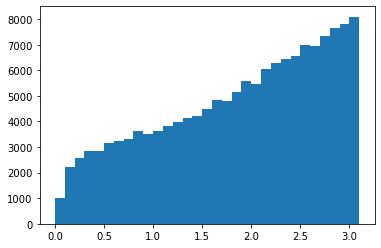

In [16]:
_ = plt.hist(data['Rm'],bins=31)
# _ = plt.hist(data['Rc'],bins=31)

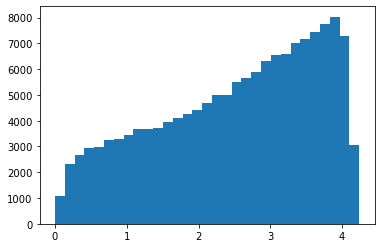

In [17]:
_ = plt.hist(data['Rc'],bins=31)

#### Cluster Example

In [18]:
mask1 = into_gal==0
mask2 = into_cls==0

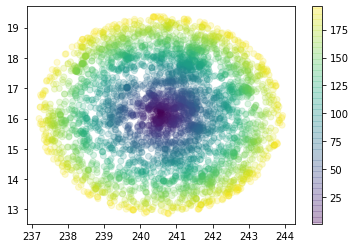

In [19]:
plt.scatter(data['ra'][mask2],data['dec'][mask2],c=data['distance'][mask2],alpha=0.2)
plt.colorbar()

### Line of Sight Velocity

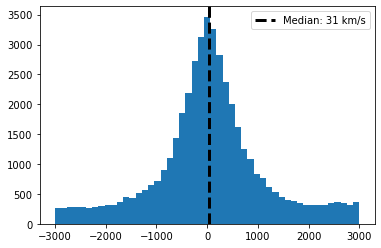

In [20]:
vmask = np.abs(vlos)<=3000.
zm = np.median(vlos[vmask])
_ = plt.hist(vlos,bins=np.linspace(-3000.,3000.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %i km/s'%zm)
plt.legend()

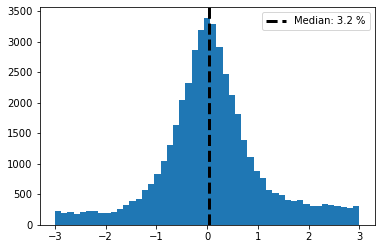

In [21]:
vm_mask = np.abs(data['vlosn'])<=3.
zm = np.median(data['vlosn'][vmask])
_ = plt.hist(data['vlosn'],bins=np.linspace(-3.,3.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %.1f %%'%(zm*100))
plt.legend()

In [73]:
## inital l.o.s velocity cut of 10.000 km/s
velocity_mask = (np.abs(data['vlos'])<10*1e3) &(data['z']>0.)

vlos_mask = (np.abs(data['vlosn'])<3.0) & (data['z']>0.)

In [74]:
print(f'Total of good galaxies: {np.count_nonzero(velocity_mask)}')
print(f'Galaxies within vlos/vcirc < 3: {np.count_nonzero(vlos_mask)}')

Total of good galaxies: 66750
Galaxies within vlos/vcirc < 3: 45679


(array([  996.,  1011.,  1837.,  4968., 12861., 13237.,  5353.,  2283.,
         1638.,  1495.]),
 array([-2.99993643e+00, -2.39994939e+00, -1.79996234e+00, -1.19997530e+00,
        -5.99988259e-01, -1.21590894e-06,  5.99985827e-01,  1.19997287e+00,
         1.79995991e+00,  2.39994695e+00,  2.99993400e+00]),
 <BarContainer object of 10 artists>)

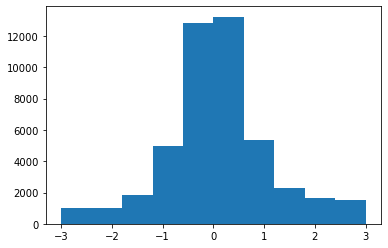

## Create Masks

I use a volume limited and a magnitude threshold sample.

In [24]:
from utils import calc_kcor
from preProcessCluster import AngularDistance

Cosmology "LCDM" 
    flat = True, Om0 = 0.2700, Ode0 = 0.7299, Ob0 = 0.0457, H0 = 70.00, sigma8 = 0.8200, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False




In [25]:
smass = 10**np.array(data['mass'])
mg = np.array(data['mg'])
mr = np.array(data['mr_petro'])
gr = mg-mr

nonzero_mass = smass>1.

In [26]:
zbins = np.arange(0.,0.3+0.01,0.01)
dmbins = AngularDistance(zbins)

In [27]:
kr_gr = calc_kcor('r',zgal,'gr',gr)
DM = 5*np.log10(np.interp(zgal,zbins,dmbins)*1e6+1e-9)-5
Mr = mr-DM-kr_gr

In [28]:
def get_percentile_curve(x,y,xbins,alpha=5,Npoints=15):
    #xbins  = np.percentile(x,np.linspace(0,100,Npoints))
    indices= [(x>=xl)&(x<xh) for xl, xh in zip(xbins[:-1],xbins[1:])]
    ycurve = np.array([np.percentile(y[idx],alpha) for idx in indices])
    return ycurve, 0.5*(xbins[1:]+xbins[:-1])

In [125]:
zmask    = velocity_mask
zcls_min = np.min(data['redshift'])
zcls_max = np.max(data['redshift'])

zinterp =  np.arange(zcls_min,np.percentile(zgal[zmask],99.9)+0.01,0.005)
ylow, zbins2 = get_percentile_curve(zgal[zmask], Mr[zmask], zinterp, Npoints=51, alpha=98)

Mr_thrshold = np.interp(zcls_max, zbins2, ylow)
Mr_th_mask = Mr<=Mr_thrshold
Mr_th_mask &= nonzero_mass
print(f'Mr thrshold: {Mr_thrshold:.2f} mag')

Mr_lim = np.interp(zgal,zbins2,ylow)
Mr_lim = np.where(zgal<zcls_min, np.max(ylow), Mr_lim)
Mr_lim = np.where(zgal>zcls_max, Mr_thrshold, Mr_lim)
Mr_mask = Mr<Mr_lim
Mr_mask &= nonzero_mass

Mr thrshold: -20.15 mag


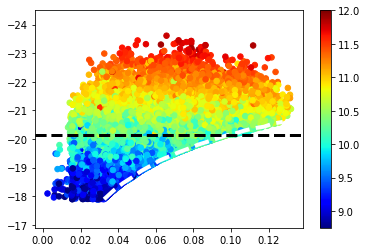

In [128]:
plt.scatter(zgal[Mr_mask&zmask],Mr[Mr_mask&zmask],c=(data['mass'][Mr_mask&zmask]),vmin=8.75,vmax=12.,s=30,cmap='jet')
plt.plot(zbins2, ylow, ls='--',lw=4,color='w')
plt.axhline(Mr_thrshold,ls='--',lw=3,color='k')
plt.ylim(np.max(ylow)+1,-24.5)
plt.colorbar()

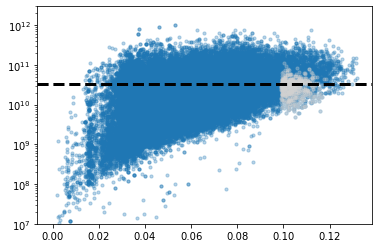

In [98]:
plt.scatter(zgal[zmask],smass[zmask],s=10,alpha=0.3)
plt.scatter(zgal[zmask&~Mr_mask],smass[zmask&~Mr_mask],s=10,alpha=0.3,color='lightgray')
plt.axhline(10**stellar_mass_th,ls='--',lw=3,color='k')
plt.ylim(1e7,3e12)
plt.yscale('log')

### Assigning new variables

In [33]:
data['Mr'] = Mr
data['kcorr_r_gr'] = kr_gr 

data['VOLUME_LIM_MASK'] = np.where(Mr_mask,1,0)
data['MAG_TH_MASK'] = np.where(Mr_th_mask,1,0)

## Assign Dynamical Classification

Assign probability for three dynamical classes: `interloper`, `orbital`, `infall`.


In [34]:
from sklearn.ensemble import RandomForestClassifier
import joblib
loaded_rf = joblib.load("/Users/jesteves/Downloads/phase_space/classification_2d_rf.joblib")

/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [35]:
rnorm_c = np.array(data['Rc'])
rnorm_m = np.array(data['Rm'])

vlosn_c = np.array(data['vlos'])
vlosn_m = np.array(data['vlosn'])

In [36]:
import pandas as pd
df2   = pd.DataFrame ({ 'r2d':rnorm_m, 'vlos':vlosn_m})
tags2 = loaded_rf.predict(df2) 
tag_probability2 = loaded_rf.predict_proba(df2) 

### Plot Distributions

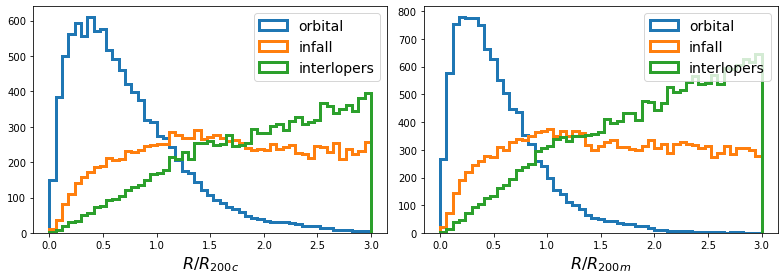

In [37]:
fig = plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
cut = (np.abs(vlosn_m)<3.)&(rnorm_c<3.)
labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(rnorm_c[cut],bins=51,weights=tag_probability2[cut,i],histtype='step', lw=3, label=labels[i],density=False)

plt.legend(fontsize=14)
plt.xlabel(r'$R/R_{200c}$',fontsize=16)
# plt.title('Normalized by: Vcir(M200c), R200c',fontsize=16)
# plt.ylim(-0.025,1.5)

plt.subplot(1, 2, 2)
cut2 = (np.abs(vlosn_m)<3.)&(rnorm_m<3.)
labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(rnorm_m[cut2],bins=51,weights=tag_probability2[cut2,i],histtype='step', lw=3, label=labels[i],density=False)

plt.legend(fontsize=14)
plt.xlabel(r'$R/R_{200m}$',fontsize=16)
# plt.title('Normalized by: Vcir(M200m), R200m',fontsize=16)
# plt.ylim(-0.025,1.5)
plt.tight_layout()
# plt.savefig('./plots/radial_distribtution_prob_weighted.png',dpi=100,facecolor='w',transparent=False)


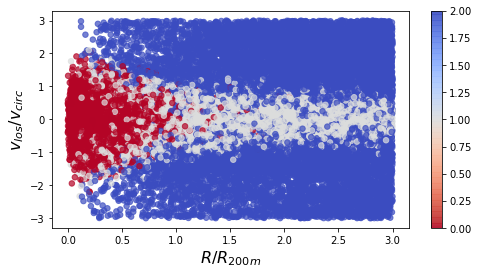

In [38]:
cut = (np.abs(vlosn_m)<3.)&(rnorm_m<3.)
plt.figure(figsize=(8,4))
plt.scatter(rnorm_m[cut],vlosn_m[cut],c=tags2[cut],alpha=0.7,s=30,cmap='coolwarm_r')
plt.xlabel(r'$R/R_{200m}$',fontsize=16)
plt.ylabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.colorbar()


In [79]:
data['VLOS_MASK'] = np.where(vlos_mask,1,0)

for i,li in enumerate(labels):
    data[li] = tags2 == i
    data['p_%s'%li] = tag_probability2[:,i]

In [40]:
# a = plt.hist(data['Rm'][cut2],weights=data['p_orbital'][cut2],histtype='step',lw=3,bins=31)
# _ = plt.hist(data['Rm'][cut2],weights=data['p_infall'][cut2],histtype='step',lw=3,bins=a[1])
# _ = plt.hist(data['Rm'][cut2],weights=data['p_interlopers'][cut2],histtype='step',lw=3,bins=a[1])

# Add Other Public Datasets

## Match with Morphology

We match our sample with Dominguez et al. 2018 morphology sample.

In [41]:
from astropy.io.fits import getdata
from astropy.table import Table

root='/Users/jesteves/Documents/localProjects/Catalogs/'
morp_fname = root+"DL_morphology_SDSS_DS18.fit"
morph = Table(getdata(morp_fname,1))

In [42]:
import smatch

nside=4096 # healpix nside
maxmatch=1 # return closest match

# ra,dec,radius in degrees
matches0 = smatch.match(data['ra'], data['dec'], 3.0/3600,
                        morph['_RAJ2000'], morph['_DEJ2000'], nside=nside, maxmatch=maxmatch)

dist = np.sqrt((data['ra'][matches0['i1'] ]-morph['_RAJ2000'][matches0['i2']])**2+
               (data['dec'][matches0['i1']]-morph['_DEJ2000'][matches0['i2']])**2)*3600

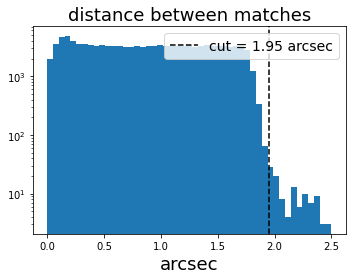

In [43]:
plt.figure(figsize=(5,4))
_ = plt.hist(dist,bins=np.linspace(0.,2.5))
plt.axvline(1.95,ls='--',color='k',label='cut = %.2f arcsec'%(1.95))
plt.yscale('log')
plt.xlabel('arcsec',fontsize=18)
plt.legend(fontsize=14)
plt.title('distance between matches',fontsize=18)
plt.tight_layout()
# plt.savefig('../plots/'+'match_distance.png')

In [44]:
matches = smatch.match(data['ra'], data['dec'], 2.9/3600, 
                       morph['_RA'], morph['_DE'], nside=nside, maxmatch=maxmatch)

## euclidean distance for small than 10 arcsec
dist = np.sqrt((data['ra'][matches0['i1']]-morph['_RA'][matches0['i2']])**2+
               (data['dec'][matches0['i1']]-morph['_DE'][matches0['i2']])**2)*3600

In [45]:
indice1 = matches['i1']
indice2 = matches['i2']
fraction = len(data[indice1])/len(data)

print('Fraction matched: %.3f'%fraction)

Fraction matched: 0.799


In [46]:
columns = morph.colnames[4:-3]

print('Selected Columns:',columns)
data['ZOO_MASK'] = 0
data['ZOO_MASK'][indice1] = 1

for col in columns:
    data[col] = -99.
    data[col][indice1] = morph[col][indice2]

Selected Columns: ['Pdisk', 'Pedgeon', 'PbarGZ2', 'PbarNair10', 'Pmerg', 'Pbulge', 'Pcigar', 'TType', 'PS0']


## Match with Bulge+Disk 

We match our sample with Mendel et al. 2014 sample.

In [47]:
root='/Users/jesteves/Documents/localProjects/Catalogs/'
morp_fname = root+"Mendel_et_al_2014/J_ApJS_210_3_dusty.csv"
morph = Table(at.read(morp_fname))

In [48]:
!cat /Users/jesteves/Documents/localProjects/Catalogs/Mendel_et_al_2014/README.txt

J/ApJS/210/3  SDSS bulge, disk and total stellar mass estimates  (Mendel+, 2014)
A catalog of bulge, disk, and total stellar mass estimates for the Sloan Digital
Sky Survey.
    Mendel J.T., Simard L., Palmer M., Ellison S.L., Patton D.R.
   <Astrophys. J. Suppl. Ser., 210, 3 (2014)>
   =2014ApJS..210....3M
ADC_Keywords: Galaxies, optical ; Models, evolutionary ;
              Surveys ; Galaxy catalogs ; Morphology ; Redshifts
Keywords: galaxies: bulges - galaxies: fundamental parameters -
          galaxies: statistics - galaxies: structure

Abstract:
    We present a catalog of bulge, disk, and total stellar mass estimates
    for ~660000 galaxies in the Legacy area of the Sloan Digital Sky
    Survey Data (SDSS) Release 7. These masses are based on a homogeneous
    catalog of g- and r-band photometry described by Simard et al. (2011,
    Cat. J/ApJS/196/11), which we extend here with bulge+disk and Sersic
    profile photometric decompositions in the SDSS u, i, and z bands. We
    

In [49]:
morph

_RAJ2000,_DEJ2000,z,logM,b_logM,B_logM,zmin,zmax,Type,logMt,b_logMt,B_logMt,logMb,b_logMb,B_logMb,logMd,b_logMd,B_logMd,PpS,dBD
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
236.3099167,0.7721667,0.01284,9.416,9.275,9.52,0.00719,0.03913,--,9.376,9.278,9.465,9.069,8.915,9.171,9.172,9.029,9.313,0.153,0.36
190.7898333,-1.2095556,0.01016,7.763,7.67,7.908,0.005,0.01107,--,7.8,7.696,7.947,7.033,6.917,7.145,7.958,7.771,8.107,0.499,0.969
204.8052083,-1.1209167,0.01485,9.386,9.246,9.569,0.01046,0.05737,--,9.422,9.269,9.594,7.946,7.605,8.126,9.483,9.308,9.611,0.687,0.333
190.3017083,-0.7568056,0.01127,8.609,8.52,8.751,0.005,0.02808,--,8.603,8.528,8.735,7.746,7.624,7.882,8.553,8.478,8.682,0.213,0.095
193.2217917,-0.8226944,0.00504,7.487,7.398,7.623,0.005,0.00852,--,7.524,7.427,7.663,--,--,--,7.546,7.44,7.679,0.486,0.132
216.443375,-0.8366944,0.01379,8.361,8.187,8.487,0.005,0.01431,--,8.31,8.171,8.433,7.996,7.965,8.061,8.11,7.939,8.256,0.506,0.306
200.6611667,-0.2818889,0.01422,9.143,8.963,9.258,0.00656,0.03571,--,9.145,8.977,9.253,8.786,8.633,8.897,8.95,8.805,9.078,0.209,0.188
202.355125,-0.3990278,0.01077,8.77,8.645,8.853,0.005,0.02247,--,8.768,8.64,8.861,7.364,7.001,7.547,8.751,8.623,8.834,0.467,0.001
204.6892917,-0.4168333,0.01296,9.208,9.084,9.374,0.00835,0.04551,--,9.36,9.179,9.469,--,--,--,9.392,9.204,9.486,0.66,0.158


In [50]:
import smatch

nside=4096 # healpix nside
maxmatch=1 # return closest match

# ra,dec,radius in degrees
matches0 = smatch.match(data['ra'], data['dec'], 3.0/3600,
                        morph['_RAJ2000'], morph['_DEJ2000'], nside=nside, maxmatch=maxmatch)

dist = np.sqrt((data['ra'][matches0['i1'] ]-morph['_RAJ2000'][matches0['i2']])**2+
               (data['dec'][matches0['i1']]-morph['_DEJ2000'][matches0['i2']])**2)*3600

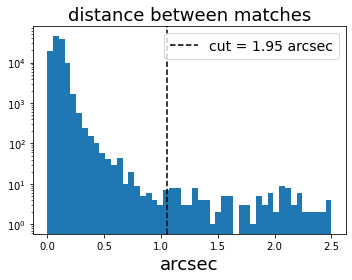

In [51]:
plt.figure(figsize=(5,4))
_ = plt.hist(dist,bins=np.linspace(0.,2.5))
plt.axvline(1.05,ls='--',color='k',label='cut = %.2f arcsec'%(1.95))
plt.yscale('log')
plt.xlabel('arcsec',fontsize=18)
plt.legend(fontsize=14)
plt.title('distance between matches',fontsize=18)
plt.tight_layout()
# plt.savefig('../plots/'+'match_distance.png')

In [52]:
matches = smatch.match(data['ra'], data['dec'], 2.5/3600, 
                       morph['_RAJ2000'], morph['_DEJ2000'], nside=nside, maxmatch=maxmatch)

## euclidean distance for small than 10 arcsec
dist = np.sqrt((data['ra'][matches0['i1']]-morph['_RAJ2000'][matches0['i2']])**2+
               (data['dec'][matches0['i1']]-morph['_DEJ2000'][matches0['i2']])**2)*3600

In [53]:
indice1 = matches['i1']
indice2 = matches['i2']

mmask = np.abs(data['z'][indice1]-morph['z'][indice2])<0.1*data['z'][indice1]

fraction = len(data[indice1[[mmask]]])/len(data)

print('Fraction matched: %.3f'%fraction)

Fraction matched: 0.785


<ipython-input-53-a771db420b98>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  fraction = len(data[indice1[[mmask]]])/len(data)


In [54]:
morph.colnames

['_RAJ2000',
 '_DEJ2000',
 'z',
 'logM',
 'b_logM',
 'B_logM',
 'zmin',
 'zmax',
 'Type',
 'logMt',
 'b_logMt',
 'B_logMt',
 'logMb',
 'b_logMb',
 'B_logMb',
 'logMd',
 'b_logMd',
 'B_logMd',
 'PpS',
 'dBD']

### Computing B/T ratio

Mainly following the procedure described in Thanjavur et al. (2016) and Bluck et al. 2014, 2022 with a small modification.

If the there is not strong statistical evidence in favour of Bulge+Disk decomposition. In the cases where, $P_{pS}>0.32$ and and the the measured B/T is within 0.3 of an extremal value (i.e. zero or one), the Sérsic stellar mass are used to the best component and the other is deemed to be negligible (set to zero). 


In [55]:
PpS = np.array(morph['PpS'])

# Bulge+Disk decomposition
massb = np.array(morph['logMb'])
massd = np.array(morph['logMd'])
# massT = np.array(morph['logMt'])
massT = np.log10(10**massb+10**massd)

# Sersic model
massS = np.array(morph['logM'])

In [56]:
bt = 10**(massb-massT)

In [57]:
bulge_mask= (bt>0.7)
disk_mask = (bt<0.3)

massb_new = np.where((PpS>0.32)&bulge_mask, massS, massb)
massd_new = np.where((PpS>0.32)&bulge_mask,  1e-6, massd)

massd_new = np.where((PpS>0.32)&disk_mask, massS, massd_new)
massb_new = np.where((PpS>0.32)&disk_mask,  1e-6, massb_new)

massT_new = np.log10(10**massb_new+10**massd_new)

bt_new = 10**(massb_new-massT_new)

Text(0, 0.5, 'B/T - w/ correction')

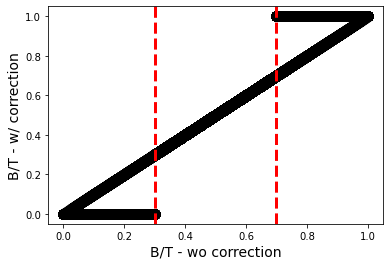

In [58]:
plt.scatter(bt,bt_new,color='k',alpha=0.01,s=100)
plt.axvline(0.7,lw=3,ls='--',color='r')
plt.axvline(0.3,lw=3,ls='--',color='r')
plt.xlabel('B/T - wo correction',fontsize=14)
plt.ylabel('B/T - w/ correction',fontsize=14)

In [59]:
# columns = morph.colnames[3:-3]
# print('Selected Columns:',columns)
data['BT_MASK'] = 0
data['BT_MASK'][indice1[mmask]] = 1

data['BT'] = -99.
data['BT'][indice1[mmask]] = bt_new[indice2[mmask]]
# data['BT'][indice1[mmask]] = bt[indice2[mmask]]

data['massT'] = -99.
data['massT'][indice1[mmask]] = massT_new[indice2[mmask]]
# data['massT'][indice1[mmask]] = massT[indice2[mmask]]

data['massB'] = -99.
data['massB'][indice1[mmask]] = massb_new[indice2[mmask]]

data['massD'] = -99.
data['massD'][indice1[mmask]] = massd_new[indice2[mmask]]

data['massS'] = -99.
data['massS'][indice1[mmask]] = massS[indice2[mmask]]

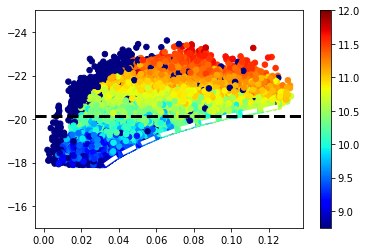

In [60]:
plt.scatter(zgal[Mr_mask&zmask],Mr[Mr_mask&zmask],c=(data['massT'][Mr_mask&zmask]),vmin=8.75,vmax=12.,s=30,cmap='jet')
plt.plot(zbins2, ylow, ls='--',lw=4,color='w')
plt.axhline(Mr_thrshold,ls='--',lw=3,color='k')
plt.ylim(-15.,-25)
plt.colorbar()

(100000000.0, 1000000000000.0)

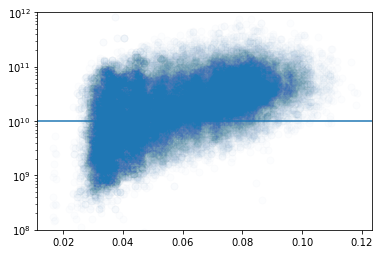

In [61]:
bt_mask = (data['BT_MASK']).astype(bool)
plt.scatter(data['z'][cut&bt_mask],10**data['mass'][cut&bt_mask],s=50,alpha=0.01)
plt.axhline(1e10)
plt.yscale('log')
plt.ylim(1e8,1e12)

(100000000.0, 1000000000000.0)

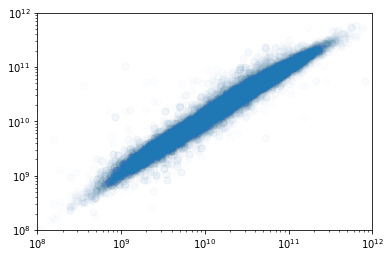

In [62]:
plt.loglog()
plt.scatter(10**data['mass'][cut&bt_mask],10**data['massT'][cut&bt_mask],s=50,alpha=0.01)
plt.ylim(1e8,1e12)
plt.xlim(1e8,1e12)

In [63]:
np.count_nonzero(data['BT_MASK'][velocity_mask])/len(data[velocity_mask])

0.9284519606021185

In [64]:
np.count_nonzero(data['ZOO_MASK'][velocity_mask])/len(data[velocity_mask])

0.9448057981787772

# Save Output Samples

In [80]:
len(data)

148692

In [81]:
data[velocity_mask]

Yang,ra,dec,distance,mr_petro,mg,mr,mass,z,zErr,bpt,ssfr,sfr,R200m,M200c,redshift,Rm,Rc,R,SF,vlos,vlosn,Mr,kcorr_r_gr,VOLUME_LIM_MASK,MAG_TH_MASK,VLOS_MASK,orbital,p_orbital,infall,p_infall,interlopers,p_interlopers,ZOO_MASK,Pdisk,Pedgeon,PbarGZ2,PbarNair10,Pmerg,Pbulge,Pcigar,TType,PS0,BT_MASK,BT,massT,massB,massD,massS
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,bool,float64,bool,float64,bool,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
2,238.56412770826,18.2407672679196,171.508636873903,16.31932,16.98568,16.19633,10.32373,0.04995852,1.184666e-05,-1,-11.56485,-1.198831,3.880159897239745,15.444902420043945,0.035999998450279236,2.71344996758414,3.6666835115118137,10.528619747386466,0,4039.2466136066228,2.1397515463114867,-20.24802456812633,0.04393046963141255,1,1,1,False,0.0,False,0.0,True,1.0,1,2.55937e-06,0.00486682,0.0153982,0.0112274,0.185477,0.961247,6.3418e-05,-2.34548,0.543602,1,0.6315343659852702,10.410603011614308,10.211,9.977,10.456
2,239.475548138904,18.460401128184,154.033811068271,17.12686,17.3434,17.02203,9.003388,0.03083848,7.006724e-06,1,-9.546676,-0.4763157,3.880159897239745,15.444902420043945,0.035999998450279236,2.43697954381946,3.2930891735475925,9.455870296321878,1,-1493.6141945330571,-0.7912275699084477,-18.425959290585133,0.02902382436247693,1,0,1,False,0.0,False,0.1,True,0.9,1,0.0795702,0.314142,0.00110089,0.425693,0.992797,0.000192321,0.891041,4.91156,0.998421,1,7.798319055423735e-10,9.108000000338677,1e-06,9.108,9.108
2,239.488718264673,18.3716150837489,148.86836495571,16.93894,17.59304,16.73839,10.47901,0.06998631,1.652068e-05,5,-11.6034,-1.080323,3.880159897239745,15.444902420043945,0.035999998450279236,2.355256664772901,3.182657090150793,9.138772458358444,0,9834.787541588561,5.209882897189332,-20.315601215058447,0.0493016459469953,1,1,0,False,0.0,False,0.0,True,1.0,1,1.77167e-05,0.000829354,0.00295514,0.26293,0.0321761,0.581499,0.00332305,-1.99257,0.97107,1,0.46666205158031393,10.50499751400524,10.174,10.232,10.592
2,239.541013372224,18.384544561721,148.369846653478,17.08099,17.43205,16.95458,9.531749,0.04581517,1.127866e-05,1,-9.952034,-0.3694099,3.880159897239745,15.444902420043945,0.035999998450279236,2.347369572346027,3.171999266309974,9.108169278617865,1,2840.264873536752,1.5046026490712163,-19.295913430620356,0.032290631311707396,1,0,1,False,0.0,False,0.0,True,1.0,1,0.389077,0.000147101,0.0343518,0.412025,0.0173447,0.00169525,0.0988745,4.09483,0.975818,1,2.3067524996757562e-10,9.637000000100182,1e-06,9.637,9.637
2,239.948953810887,18.1955300132629,129.870359401985,17.56118,17.94633,17.52355,8.965192,0.03186652,5.389447e-06,1,-9.753775,-0.7377419,3.880159897239745,15.444902420043945,0.035999998450279236,2.0546879092074346,2.7764986891212944,7.972517626650066,1,-1196.1251607653496,-0.6336356521803079,-18.059359336951164,0.02872287707692768,1,0,1,False,0.05,False,0.15,True,0.8,1,0.00257769,0.840802,0.0808437,0.293939,0.594099,0.00237444,0.989634,1.52224,0.921552,1,0.30144137358197653,9.09679713992718,8.576,8.941,9.059
2,239.79196968823,18.8328015037894,169.104358895431,16.30663,16.8925,16.08812,10.55266,0.05817529,1.30255e-05,4,-11.66858,-1.064265,3.880159897239745,15.444902420043945,0.035999998450279236,2.675411719938661,3.61528244751038,10.381025264311205,0,6416.974102801095,3.399329521712295,-20.568878536319872,0.042721013542467365,1,1,0,False,0.0,False,0.0,True,1.0,1,0.000785152,0.00881881,0.00966416,0.159861,0.0761877,0.738272,0.150814,-1.90044,0.858162,1,0.5464926527086947,10.579415672524014,10.317,10.236,10.635
2,238.834156030598,18.5379217789529,175.985046399748,16.36351,17.05342,16.26204,10.41423,0.04450383,1.689649e-05,2,-10.61962,-0.1506978,3.880159897239745,15.444902420043945,0.035999998450279236,2.784271551290901,3.7623846802597063,10.803418

In [82]:
print(f'Saving file: {fl.galaxy}')
print(f'Number of Galaxies: {len(data[velocity_mask])}')
data[velocity_mask].write(fl.galaxy,format='csv',overwrite=True)

Saving file: ./data/catalogs/SDSS/groups_deCarvalho2017_R200m_galaxies_final_flag_johnnyheq_pp.csv
Number of Galaxies: 66750
